# Data Preparation

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, StratifiedKFold, LeaveOneOut, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')


In [2]:
def read_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Return the DataFrame
    return df

# Usage example
df = read_csv('car_price.csv')
df.head()

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


# Data Cleaning

In [3]:
# Function that drops columns
def drop_columns(dataframe, columns_to_drop):

    # If a single column name is provided, convert it to a list
    if isinstance(columns_to_drop, str):
        columns_to_drop = [columns_to_drop]

    # Drop the specified columns
    modified_dataframe = dataframe.drop(columns=columns_to_drop, axis=1)

    return modified_dataframe

#example
df = drop_columns(df, ['Unnamed: 0'])
df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


In [4]:
# Function that detects missing values per columns
def detect_missing_values(dataframe):

    # Get the total number of missing values in the dataframe
    missing_values = dataframe.isnull().sum()

    # Return the number of missing values
    return missing_values

#example
detect_missing_values(df)

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

In [5]:
#Function that converts column with strings to numerical values only
def convert_comma_to_dot(column):
    try:
        # Replace commas with periods
        column = column.replace(',', '.')

        return column
    except AttributeError:
        return None
    
def convert_price(column):
    
    num_value = float(column.split(" ")[0])

    if 'Crore' in column:
        return num_value * 10000000
    elif 'Lakh' in column:
        return num_value * 100000
    else:
        return num_value

# Remove the string in the engine column
def convert_engine(column):
    try:
        num_value = float(column.split(" ")[0])
        return num_value
    except ValueError:
        return None

# Remove the string in the power kms_driven
def convert_kms(column):
    try:
        # Remove commas and 'kms', then convert to integer
        return int(column.replace(',', '').replace(' kms', ''))
    except ValueError:
        return None
    
# Remove the string in the Seats column
def convert_seats(seats_str):
    try:
        return int(seats_str.replace(' Seats', ''))
    except ValueError:
        return None
    
# Extract the first word
def keep_first_word(input_string):
    all_words = input_string.split()
    if all_words:
        return all_words[0]
    else:
        return None

# Remove the string in the ownership column
def extract_first_integer(ownership_str):
    try:
        return int(''.join(filter(str.isdigit, ownership_str)))
    except ValueError:
        return None
    
def process_ownership(df):
    # Create a new column 'num_users' by applying the extract_first_integer function
    df['num_owners'] = df['ownership'].apply(extract_first_integer)

    # Drop the original 'ownership' column
    df.drop(columns=['ownership'], inplace=True)

    return df

# Apply the conversion function to the 'price' column
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(convert_comma_to_dot)
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(convert_price)

# Apply the conversion function to the 'kms_driven' column
df['kms_driven'] = df['kms_driven'].apply(convert_kms)

# Apply the conversion function to the 'engine' column
df['engine'] = df['engine'].apply(convert_engine)

# Apply the conversion function to the 'seats' column
df['Seats'] = df['Seats'].apply(convert_seats)

# Keep the first word of the column car
df['car_name'] = df['car_name'].apply(keep_first_word)

# Call the preprocess_data function to handle the ownership column
df = process_ownership(df)

# Display the modified DataFrame
df.head(20)

#example
#detect_missing_values(df)
        


,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,manufacture,engine,Seats,num_owners
0,Jeep,1003000.0,86226,Diesel,Manual,2017,1956.0,5,1
1,Renault,1283000.0,13248,Petrol,Automatic,2021,1330.0,5,1
2,Toyota,1640000.0,60343,Petrol,Automatic,2016,2494.0,5,1
3,Honda,777000.0,26696,Petrol,Automatic,2018,1199.0,5,1
4,Volkswagen,515000.0,69414,Petrol,Manual,2016,1199.0,5,1
5,Volkswagen,766000.0,49719,Petrol,Automatic,2017,1197.0,5,1
6,Volkswagen,758000.0,43688,Petrol,Automatic,2017,1197.0,5,1
7,Honda,1160000.0,14470,Diesel,Manual,2021,1498.0,5,1
8,Honda,699000.0,21429,Petrol,Automatic,2015,1497.0,5,1
9,Renault,753000.0,31750,Petrol,Automatic,2017,1498.0,5,1


In [6]:
'''# Correlation Matrix
def correlation_heatmap(df, columns):
    corr = df[columns].corr()
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")
    heatmap.set_title('Correlation Matrix', fontdict={'fontsize': 18})
    plt.show()

# Example 
correlation_heatmap(df, ['car_prices_in_rupee', 'kms_driven','transmission','engine','manufacture','Seats','num_owners'])

#
all_columns = df.columns.tolist()  
correlation_heatmap(df, all_columns)
'''

'# Correlation Matrix\ndef correlation_heatmap(df, columns):\n    corr = df[columns].corr()\n    plt.figure(figsize=(10, 8))\n    heatmap = sns.heatmap(corr, annot=True, cmap=\'viridis\', fmt=".2f")\n    heatmap.set_title(\'Correlation Matrix\', fontdict={\'fontsize\': 18})\n    plt.show()\n\n# Example \ncorrelation_heatmap(df, [\'car_prices_in_rupee\', \'kms_driven\',\'transmission\',\'engine\',\'manufacture\',\'Seats\',\'num_owners\'])\n\n#\nall_columns = df.columns.tolist()  \ncorrelation_heatmap(df, all_columns)\n'

In [7]:
#example
detect_missing_values(df)

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
manufacture            0
engine                 0
Seats                  0
num_owners             0
dtype: int64

In [8]:
#function for binary variables where we specify the true and false values
def columns_binary(df, column_names: list, true_value, false_value):
    for column_name in column_names:
        df[column_name] = df[column_name].replace({true_value: 1, false_value: 0})
    return df

df = columns_binary(df, ['transmission'], 'Automatic', 'Manual')

df.head(20)

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,manufacture,engine,Seats,num_owners
0,Jeep,1003000.0,86226,Diesel,0,2017,1956.0,5,1
1,Renault,1283000.0,13248,Petrol,1,2021,1330.0,5,1
2,Toyota,1640000.0,60343,Petrol,1,2016,2494.0,5,1
3,Honda,777000.0,26696,Petrol,1,2018,1199.0,5,1
4,Volkswagen,515000.0,69414,Petrol,0,2016,1199.0,5,1
5,Volkswagen,766000.0,49719,Petrol,1,2017,1197.0,5,1
6,Volkswagen,758000.0,43688,Petrol,1,2017,1197.0,5,1
7,Honda,1160000.0,14470,Diesel,0,2021,1498.0,5,1
8,Honda,699000.0,21429,Petrol,1,2015,1497.0,5,1
9,Renault,753000.0,31750,Petrol,1,2017,1498.0,5,1


In [9]:
#example
detect_missing_values(df)

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
manufacture            0
engine                 0
Seats                  0
num_owners             0
dtype: int64

In [10]:
def one_hot_encode(df, columns_to_encode):
    df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)
    return df_encoded

# Define the columns to one-hot encode
columns_to_encode = ['fuel_type', 'car_name']

# Apply the one_hot_encode function
df = one_hot_encode(df, columns_to_encode)

#prepared_df.head()
df.head(20)

,car_prices_in_rupee,kms_driven,transmission,manufacture,engine,Seats,num_owners,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,...,car_name_Mitsubishi,car_name_Nissan,car_name_Porsche,car_name_Premier,car_name_Renault,car_name_Skoda,car_name_Tata,car_name_Toyota,car_name_Volkswagen,car_name_Volvo
0,1003000.0,86226,0,2017,1956.0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1283000.0,13248,1,2021,1330.0,5,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1640000.0,60343,1,2016,2494.0,5,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,777000.0,26696,1,2018,1199.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,515000.0,69414,0,2016,1199.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,766000.0,49719,1,2017,1197.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,758000.0,43688,1,2017,1197.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,1160000.0,14470,0,2021,1498.0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,699000.0,21429,1,2015,1497.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,753000.0,31750,1,2017,1498.0,5,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [11]:
#example
detect_missing_values(df)

car_prices_in_rupee       0
kms_driven                0
transmission              0
manufacture               0
engine                    0
Seats                     0
num_owners                0
fuel_type_Diesel          0
fuel_type_Electric        0
fuel_type_Lpg             0
fuel_type_Petrol          0
car_name_BMW              0
car_name_Bentley          0
car_name_Chevrolet        0
car_name_Datsun           0
car_name_Fiat             0
car_name_Force            0
car_name_Ford             0
car_name_Honda            0
car_name_Hyundai          0
car_name_Isuzu            0
car_name_Jaguar           0
car_name_Jeep             0
car_name_Kia              0
car_name_Land             0
car_name_Lexus            0
car_name_MG               0
car_name_Mahindra         0
car_name_Maruti           0
car_name_Maserati         0
car_name_Mercedes-Benz    0
car_name_Mini             0
car_name_Mitsubishi       0
car_name_Nissan           0
car_name_Porsche          0
car_name_Premier    

In [12]:
# Function that replaces missing values 

# Function to fill missing values with the mean
def column_fill_mean(df, column_name:str):
    df[column_name].fillna(df[column_name].mean(), inplace=True)
    return df

# fill missing values by random from the distribution
def distributed_fill(df, column_name):
    distribution = df[column_name].dropna()
    missing_count = df[column_name].isnull().sum()
    random_samples = np.random.choice(distribution, missing_count)
    df.loc[df[column_name].isnull(), column_name] = random_samples
    return df

# fill missing values with KNN
def column_fill_KNN(df, column_name:str, neighbors=10):
    imputer = KNNImputer()
    imputed_data = imputer.fit_transform(df)
    df_temp = pd.DataFrame(imputed_data)
    df_temp.columns = df.columns
    df[column_name] = df_temp[column_name]
    return df



In [13]:
df.head()


,car_prices_in_rupee,kms_driven,transmission,manufacture,engine,Seats,num_owners,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,...,car_name_Mitsubishi,car_name_Nissan,car_name_Porsche,car_name_Premier,car_name_Renault,car_name_Skoda,car_name_Tata,car_name_Toyota,car_name_Volkswagen,car_name_Volvo
0,1003000.0,86226,0,2017,1956.0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1283000.0,13248,1,2021,1330.0,5,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1640000.0,60343,1,2016,2494.0,5,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,777000.0,26696,1,2018,1199.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,515000.0,69414,0,2016,1199.0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Data Exploration (graph (correlation and density), outliers, normality test,...)

In [14]:
# Function to check outliers using quantiles
def check_outliers_quantiles(df):
    outliers = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            q1 = df[column].quantile(0.10)
            q3 = df[column].quantile(0.90)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            outliers_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
            outliers[column] = outliers_count

    print("Outliers in each numeric column based on quantiles method:")
    for col, count in outliers.items():
        print(f"Column '{col}': {count} outliers")

    return outliers

# Example
outliers_dict = check_outliers_quantiles(df)

Outliers in each numeric column based on quantiles method:
Column 'car_prices_in_rupee': 132 outliers
Column 'kms_driven': 22 outliers
Column 'transmission': 0 outliers
Column 'manufacture': 0 outliers
Column 'engine': 41 outliers
Column 'Seats': 0 outliers
Column 'num_owners': 96 outliers
Column 'fuel_type_Diesel': 0 outliers
Column 'fuel_type_Electric': 14 outliers
Column 'fuel_type_Lpg': 28 outliers
Column 'fuel_type_Petrol': 0 outliers
Column 'car_name_BMW': 172 outliers
Column 'car_name_Bentley': 1 outliers
Column 'car_name_Chevrolet': 82 outliers
Column 'car_name_Datsun': 25 outliers
Column 'car_name_Fiat': 17 outliers
Column 'car_name_Force': 1 outliers
Column 'car_name_Ford': 168 outliers
Column 'car_name_Honda': 498 outliers
Column 'car_name_Hyundai': 0 outliers
Column 'car_name_Isuzu': 4 outliers
Column 'car_name_Jaguar': 30 outliers
Column 'car_name_Jeep': 49 outliers
Column 'car_name_Kia': 61 outliers
Column 'car_name_Land': 50 outliers
Column 'car_name_Lexus': 10 outliers


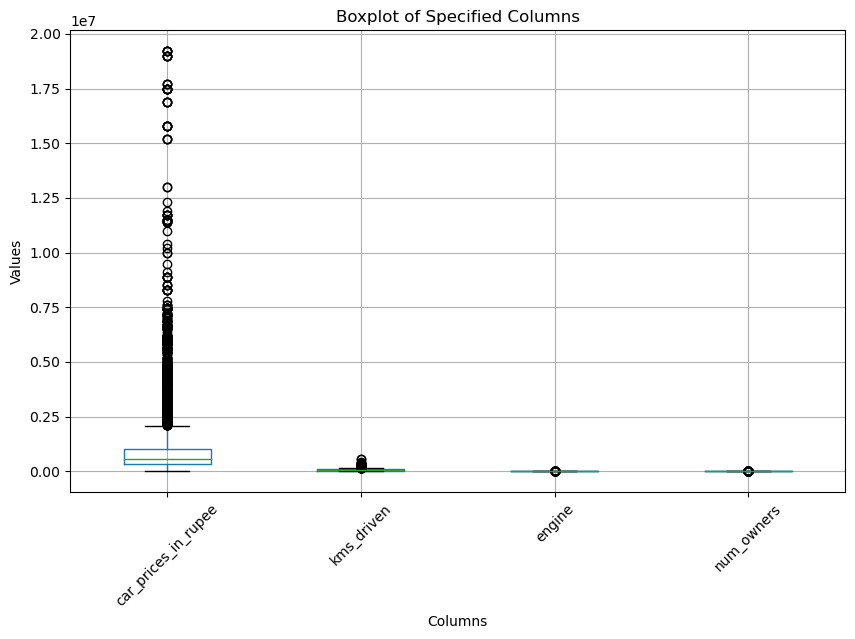

In [15]:
# Function to create boxplots for specified columns
def create_boxplots(df, columns):
    fig, ax = plt.subplots(figsize=(10, 6))
    df.boxplot(column=columns, ax=ax)
    plt.title('Boxplot of Specified Columns')
    plt.ylabel('Values')
    plt.xlabel('Columns')
    plt.xticks(rotation=45)
    plt.show()
    
# Assuming 'df' is your DataFrame and 'selected_columns' is the list of columns to plot
create_boxplots(df, ['car_prices_in_rupee', 'kms_driven', 'engine', 'num_owners'])

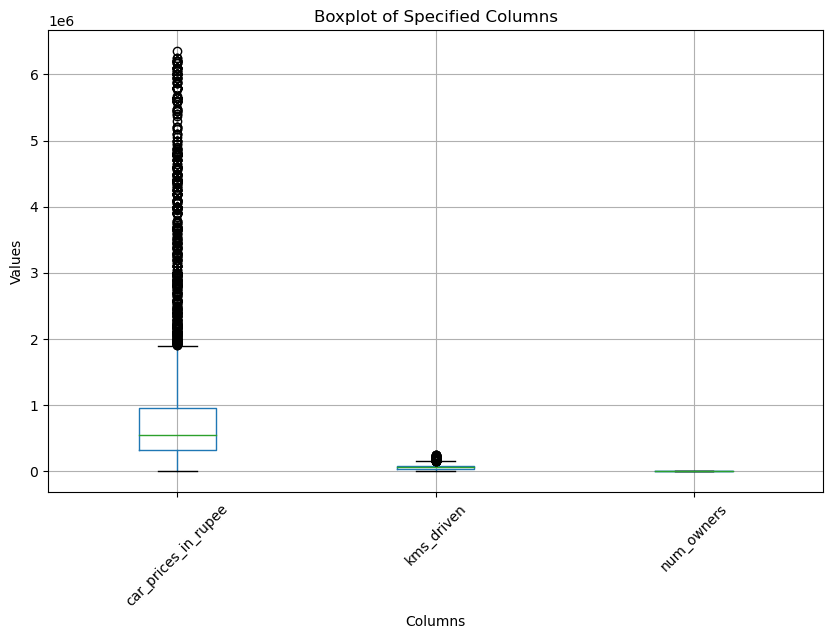

In [16]:
# Handle outliers -> replace values with KNN
def handle_outliers_KNN(df, column_name:str):
    df_copy = df.copy()
    column_data = df_copy[[column_name]].values
    Q1 = np.percentile(column_data, 10)
    Q3 = np.percentile(column_data, 90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_copy[column_name] = np.where((column_data < lower_bound) | (column_data > upper_bound), np.nan, column_data)

    df_copy = column_fill_KNN(df_copy, column_name)
    return df_copy

# Handle outliers -> replace values with mean
def handle_outliers_mean(df, column_name:str):
    df_copy = df.copy()
    column_data = df_copy[[column_name]].values
    Q1 = np.percentile(column_data, 10)
    Q3 = np.percentile(column_data, 90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_copy[column_name] = np.where((column_data < lower_bound) | (column_data > upper_bound), np.nan, column_data)
    df_copy[column_name].fillna(df_copy[column_name].mean(), inplace=True)
    return df_copy

#example
df = handle_outliers_mean(df, 'car_prices_in_rupee')
df = handle_outliers_mean(df, 'kms_driven')
df = handle_outliers_mean(df, 'num_owners')

create_boxplots(df, ['car_prices_in_rupee', 'kms_driven', 'num_owners'])


In [17]:
#Function to check the range of values in each column
def check_range(df):
    for column in df.select_dtypes(include=['int64', 'float64']).columns:
        min_val = df[column].min()
        max_val = df[column].max()
        print(f"{column}: Min = {min_val}, Max = {max_val}")


# Example 
ranges = check_range(df)


car_prices_in_rupee: Min = 35.0, Max = 6350000.0
kms_driven: Min = 250.0, Max = 249535.0
transmission: Min = 0, Max = 1
manufacture: Min = 1995, Max = 2022
engine: Min = 0.0, Max = 5950.0
Seats: Min = 2, Max = 8
num_owners: Min = 0.0, Max = 3.0


In [18]:
df.head()

,car_prices_in_rupee,kms_driven,transmission,manufacture,engine,Seats,num_owners,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,...,car_name_Mitsubishi,car_name_Nissan,car_name_Porsche,car_name_Premier,car_name_Renault,car_name_Skoda,car_name_Tata,car_name_Toyota,car_name_Volkswagen,car_name_Volvo
0,1003000.0,86226.0,0,2017,1956.0,5,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1283000.0,13248.0,1,2021,1330.0,5,1.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1640000.0,60343.0,1,2016,2494.0,5,1.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,777000.0,26696.0,1,2018,1199.0,5,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,515000.0,69414.0,0,2016,1199.0,5,1.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
# Function to check normality
def test_normality(data, column_name, alpha=0.05):
    # normality test
    stat, p = shapiro(data)
    result = f'Column "{column_name}" looks Gaussian (fail to reject H0)' if p > alpha else f'Column "{column_name}" is not normally distributed (reject H0)'
    interpretation = f'Column "{column_name}": Statistics={stat:.3f}, p={p:.3f}. {result}'
    print(interpretation)

# Usage example
test_normality(df['car_prices_in_rupee'], 'car_prices_in_rupee')
test_normality(df['kms_driven'], 'kms_driven')
test_normality(df['engine'], 'engine')
test_normality(df['manufacture'], 'manufacture')


Column "car_prices_in_rupee": Statistics=0.656, p=0.000. Column "car_prices_in_rupee" is not normally distributed (reject H0)
Column "kms_driven": Statistics=0.954, p=0.000. Column "kms_driven" is not normally distributed (reject H0)
Column "engine": Statistics=0.850, p=0.000. Column "engine" is not normally distributed (reject H0)
Column "manufacture": Statistics=0.965, p=0.000. Column "manufacture" is not normally distributed (reject H0)


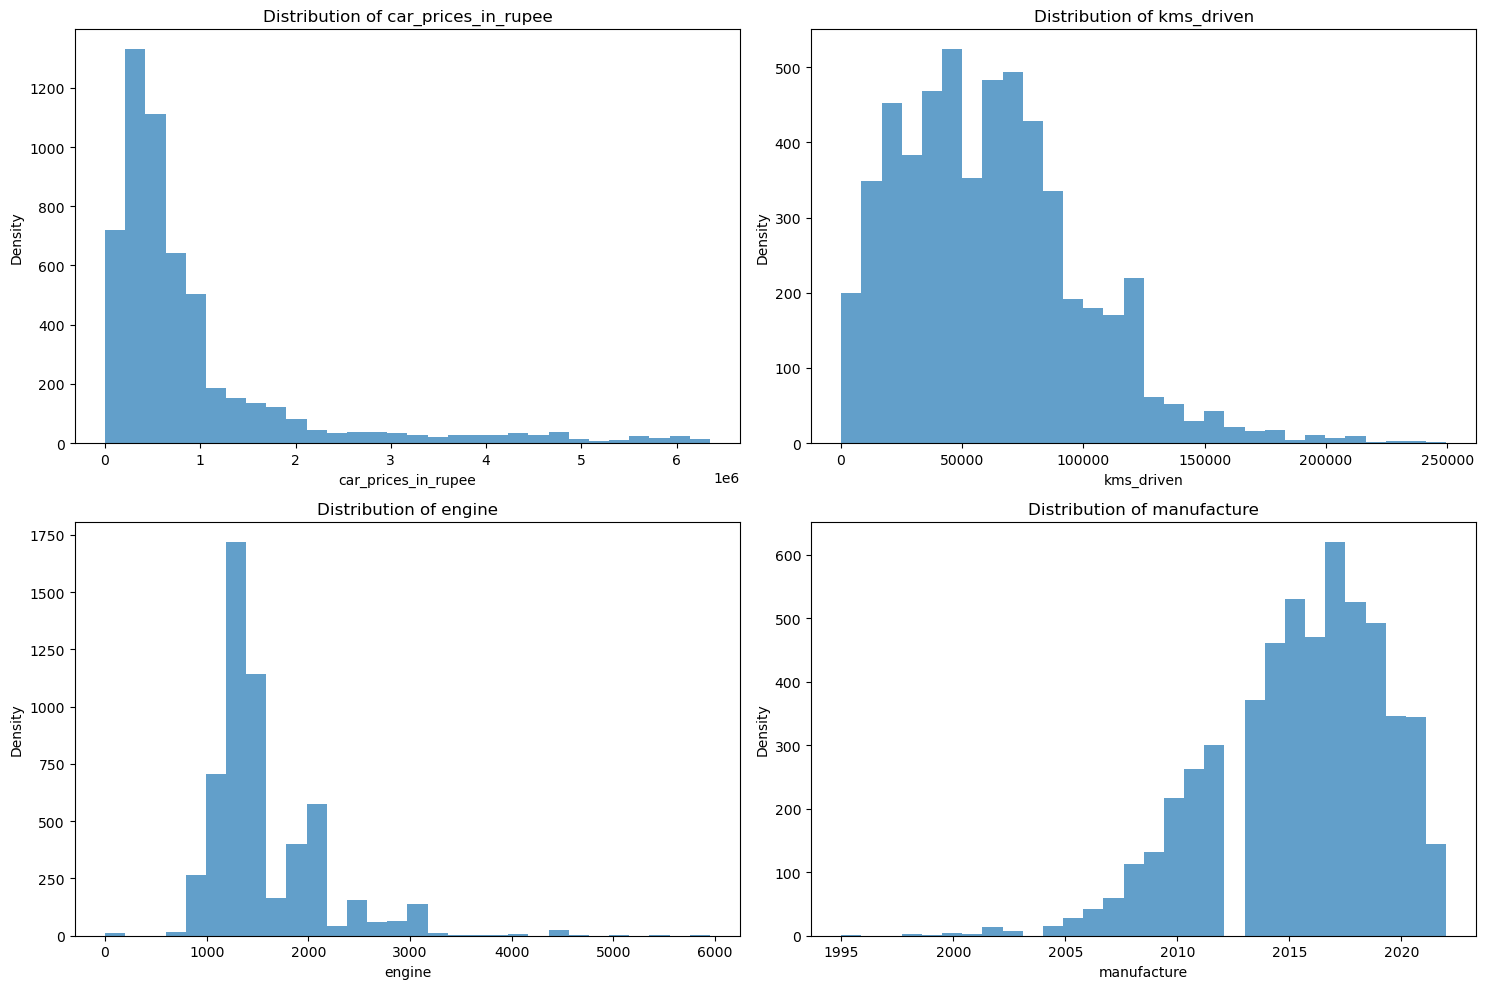

In [20]:
# Plotting the distribution of the data

def plot_distribution(df, columns):
    num_cols = len(columns)
    num_rows = (num_cols // 2) + (num_cols % 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]
        ax.hist(df[col], bins=30, alpha=0.7)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')

    plt.tight_layout()
    plt.show()

# Usage example
plot_distribution(df, ['car_prices_in_rupee', 'kms_driven', 'engine','manufacture'])


# Data Transformation

In [21]:
# normalization, standardization, log ttansformation
def scaling_normalization(df, column_name:str):
    df[column_name] = (df[column_name] - df[column_name].min()) / (df[column_name].max() - df[column_name].min())
    return df

def scaling_standardization(df, column_name:str):
    df[column_name] = (df[column_name] - df[column_name].mean()) / df[column_name].std()
    return df

def log_transformation(df, column_name:str):
    df[column_name] = np.log(df[column_name])
    return df

#square transformation
def square_transformation(df, column_name:str):
    df[column_name] = np.square(df[column_name])
    return df

#example transforamtions
df = log_transformation(df, 'car_prices_in_rupee')
df = log_transformation(df, 'kms_driven')
df = scaling_normalization(df, 'engine')
df = scaling_normalization(df, 'manufacture')

# Usage example
test_normality(df['car_prices_in_rupee'], 'car_prices_in_rupee')
test_normality(df['kms_driven'], 'kms_driven')
test_normality(df['engine'], 'engine')
test_normality(df['manufacture'], 'manufacture')


Column "car_prices_in_rupee": Statistics=0.659, p=0.000. Column "car_prices_in_rupee" is not normally distributed (reject H0)
Column "kms_driven": Statistics=0.924, p=0.000. Column "kms_driven" is not normally distributed (reject H0)
Column "engine": Statistics=0.850, p=0.000. Column "engine" is not normally distributed (reject H0)
Column "manufacture": Statistics=0.965, p=0.000. Column "manufacture" is not normally distributed (reject H0)


In [22]:
#missing values
detect_missing_values(df)

car_prices_in_rupee       0
kms_driven                0
transmission              0
manufacture               0
engine                    0
Seats                     0
num_owners                0
fuel_type_Diesel          0
fuel_type_Electric        0
fuel_type_Lpg             0
fuel_type_Petrol          0
car_name_BMW              0
car_name_Bentley          0
car_name_Chevrolet        0
car_name_Datsun           0
car_name_Fiat             0
car_name_Force            0
car_name_Ford             0
car_name_Honda            0
car_name_Hyundai          0
car_name_Isuzu            0
car_name_Jaguar           0
car_name_Jeep             0
car_name_Kia              0
car_name_Land             0
car_name_Lexus            0
car_name_MG               0
car_name_Mahindra         0
car_name_Maruti           0
car_name_Maserati         0
car_name_Mercedes-Benz    0
car_name_Mini             0
car_name_Mitsubishi       0
car_name_Nissan           0
car_name_Porsche          0
car_name_Premier    

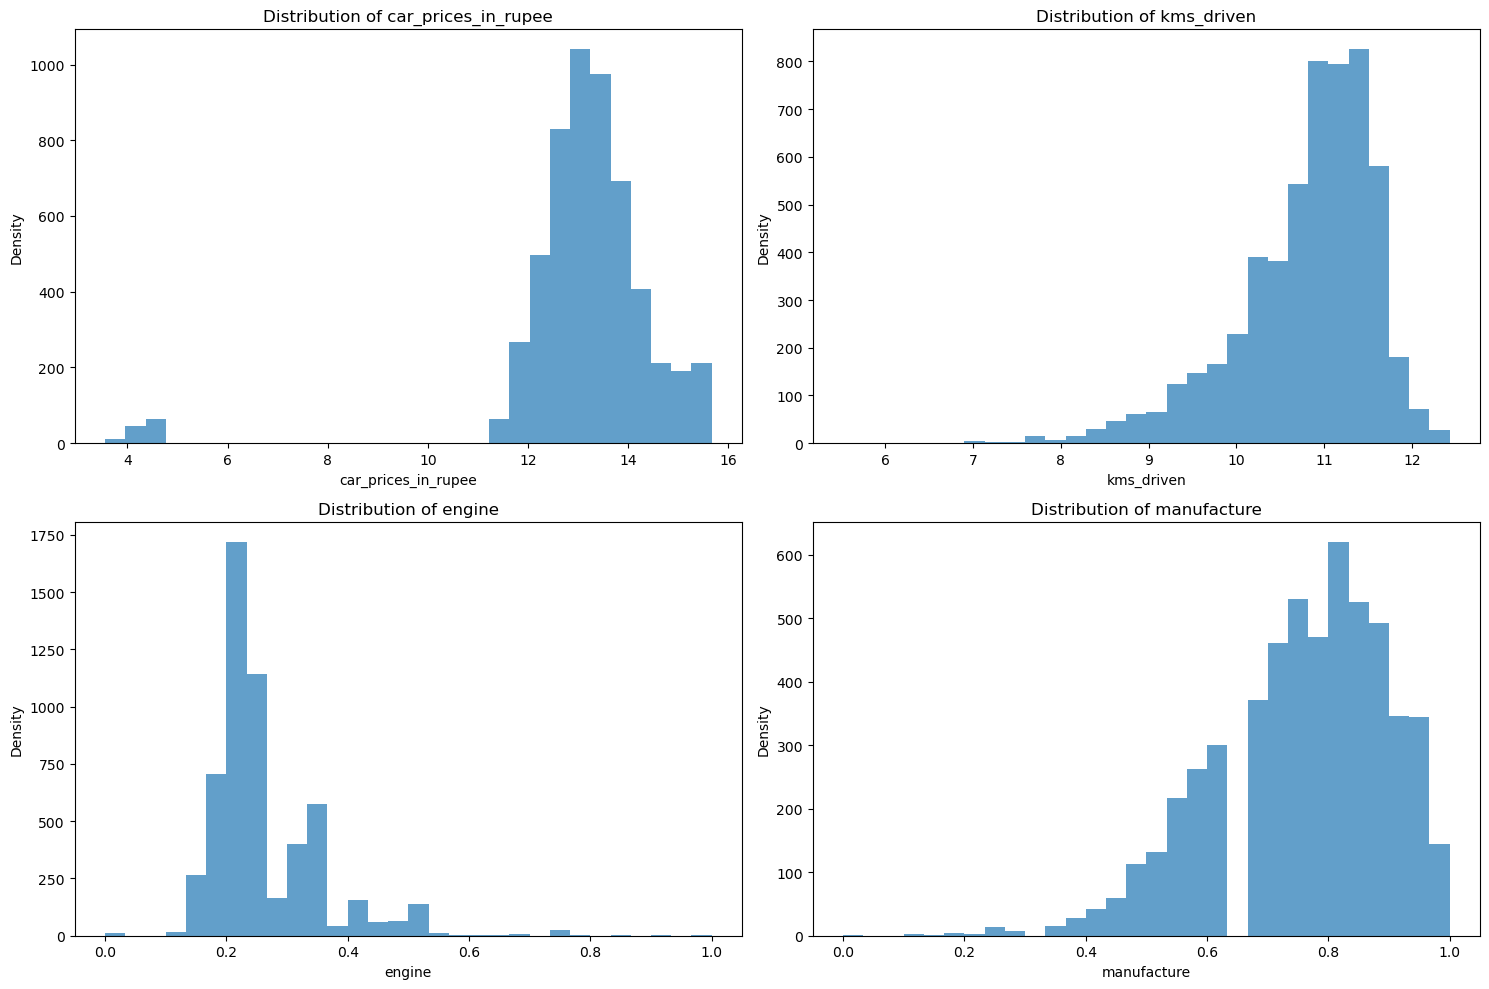

In [23]:
# Usage example
plot_distribution(df, ['car_prices_in_rupee', 'kms_driven', 'engine','manufacture'])

In [24]:
df.head()

,car_prices_in_rupee,kms_driven,transmission,manufacture,engine,Seats,num_owners,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,...,car_name_Mitsubishi,car_name_Nissan,car_name_Porsche,car_name_Premier,car_name_Renault,car_name_Skoda,car_name_Tata,car_name_Toyota,car_name_Volkswagen,car_name_Volvo
0,13.818506,11.364727,0,0.814815,0.328739,5,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14.064712,9.491602,1,0.962963,0.223529,5,1.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,14.310207,11.007800,1,0.777778,0.419160,5,1.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,13.563196,10.192269,1,0.851852,0.201513,5,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13.151922,11.147844,0,0.777778,0.201513,5,1.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


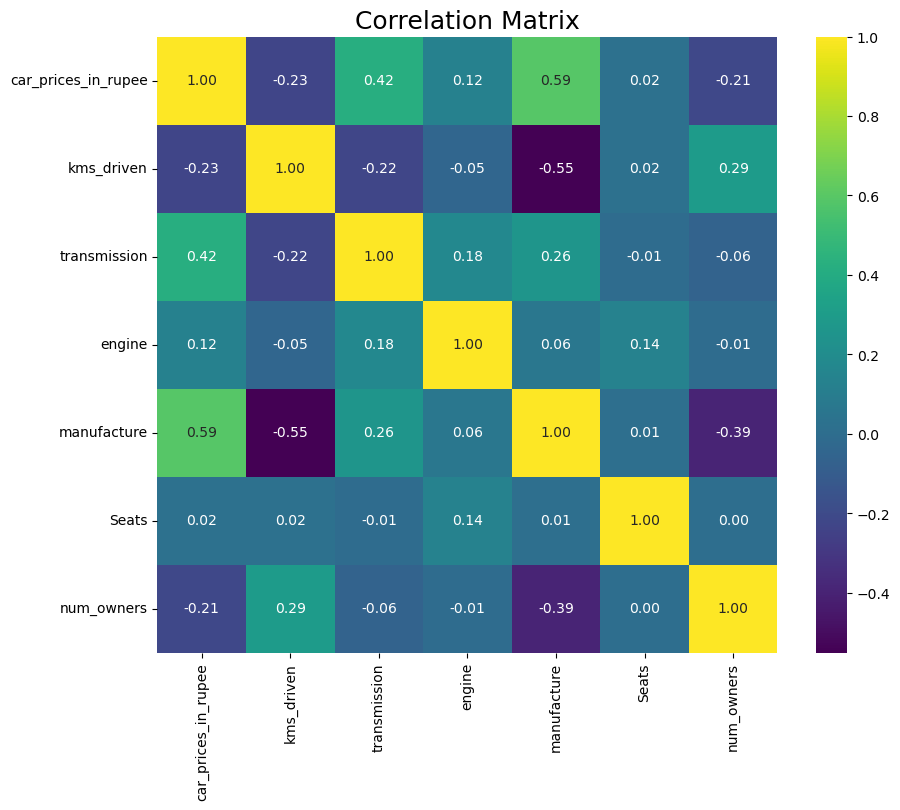

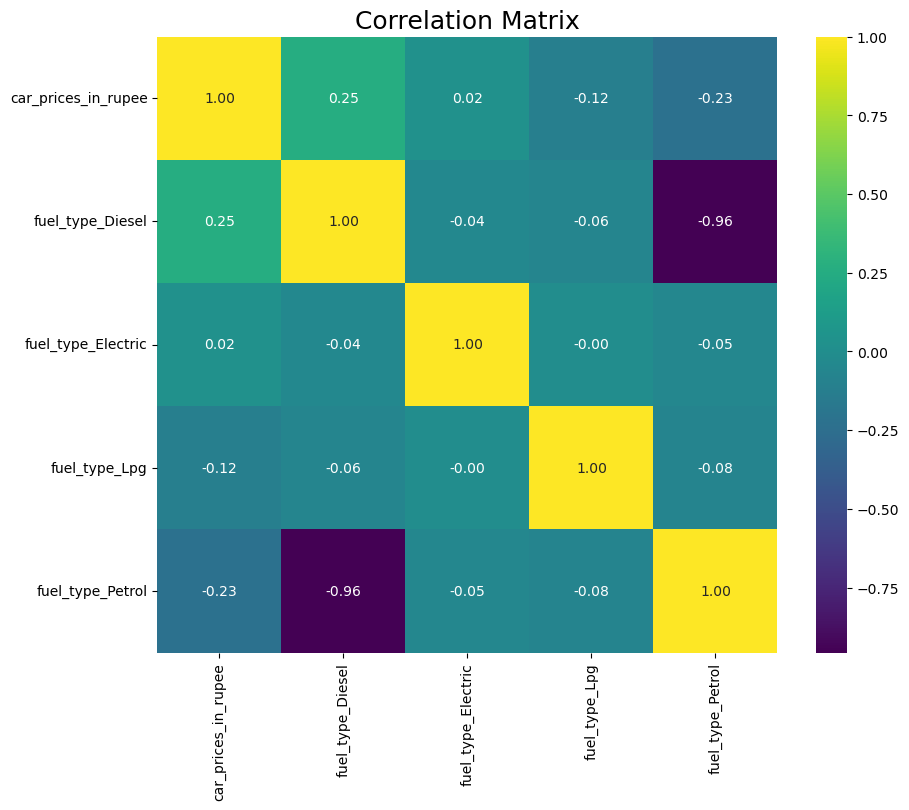

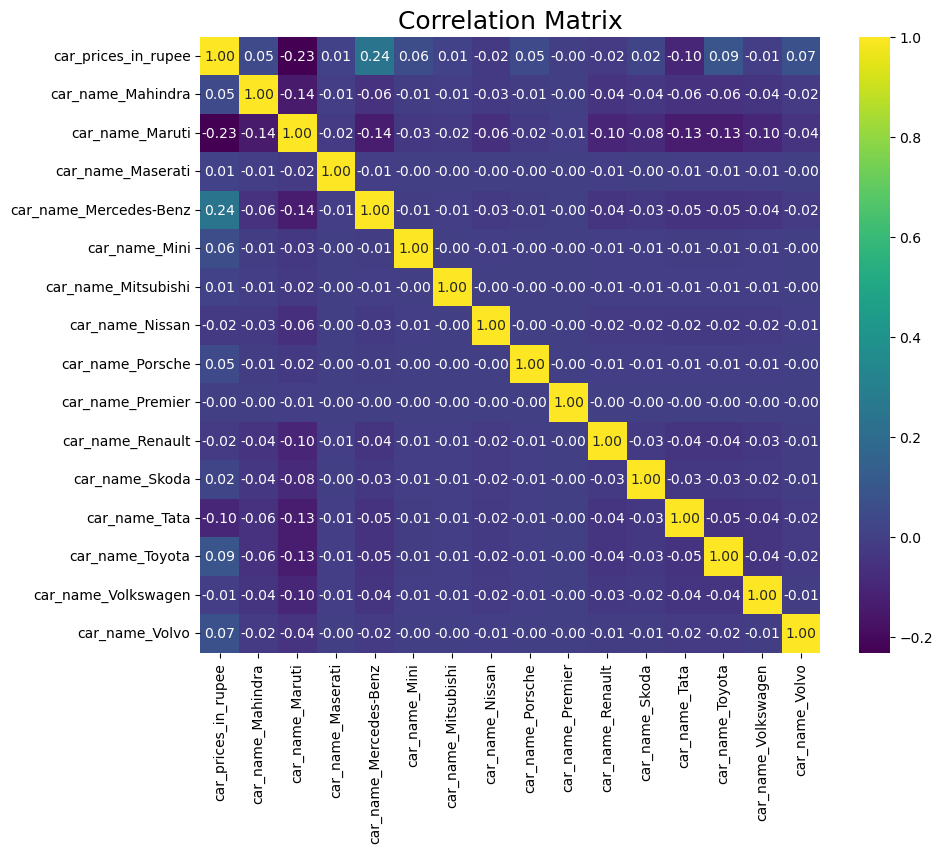

In [25]:
# Correlation Matrix
def correlation_heatmap(df, columns):
    corr = df[columns].corr()
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")
    heatmap.set_title('Correlation Matrix', fontdict={'fontsize': 18})
    plt.show()

# Example with numerical variable
correlation_heatmap(df, ['car_prices_in_rupee', 'kms_driven','transmission','engine','manufacture','Seats','num_owners'])

# Fuel type
fuel_types_columns = ['car_prices_in_rupee','fuel_type_Diesel', 'fuel_type_Electric','fuel_type_Lpg','fuel_type_Petrol']
correlation_heatmap(df, fuel_types_columns)

#Car Company
first_column = df.columns[0]  # Get the first column name
last_15_columns = df.columns[-15:].tolist()  # Get the last 15 column names
columns_for_heatmap = [first_column] + last_15_columns  # Combine the first column with the last 15 columns
correlation_heatmap(df, columns_for_heatmap)


# Model

In [26]:
print(df.shape)

(5512, 42)


In [27]:
# Splitting into train and test sets

X = df.drop('car_prices_in_rupee', axis = 1) # Selecting independent features 
y = df['car_prices_in_rupee'] # Selecting target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [28]:
print(X_test.shape)

(1654, 41)


In [29]:
# Linear Regression
def linear_regression(X_train,y_train,X_test,y_test):
    linear = LinearRegression()
    linear.fit(X_train, y_train)
    y_pred = linear.predict(X_test)
    
    #Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test-y_pred)
    r2 = r2_score(y_test, y_pred)   
    return mse, mse_std, r2, y_pred

# Polynomial Regression
def polynomial_regression(X_train, y_train, X_test, y_test, degree=2):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly_train = poly_features.fit_transform(X_train)
    X_poly_test = poly_features.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    y_pred = model.predict(X_poly_test)
    
    #Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mse_std, r2, y_pred

#Lasso Regression
def lasso_regression(X_train, y_train, X_test, y_test, alpha = 0.0):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_test)
        
    #Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mse_std, r2, y_pred

#Lasso Regression with Cross Validation
def lasso_regression_cv(X_train, y_train, X_test, y_test, alphas=0.0, cv=5):
    lasso_cv = LassoCV(alphas=alphas, cv=cv, max_iter=100000)
    lasso_cv.fit(X_train, y_train)
    
    y_pred = lasso_cv.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mse_std, r2, y_pred

#Lasso Regression
def ridge_regression(X_train, y_train, X_test, y_test, alpha=0.95):
    ridge = ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    y_pred = ridge.predict(X_test)
        
    #Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mse_std, r2, y_pred

#Lasso Regression with Cross Validation
def ridge_regression_cv(X_train, y_train, X_test, y_test, alphas=0.95, cv=5):
    ridge_cv = RidgeCV(alphas=alphas, cv=cv, max_iter=100000)
    ridge_cv.fit(X_train, y_train)
    
    y_pred = ridge_cv.predict(X_test)
    
    #Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mse_std, r2, y_pred

# Gradient Boosting Regression
def gradient_boosting_train(X_train, y_train, X_test, y_test, params_gb= None):
    gb_regressor = GradientBoostingRegressor(**params_gb)
    gb_regressor.fit(X_train, y_train)
    
    y_pred = gb_regressor.predict(X_test)
    
    #Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mse_std, r2, y_pred

# Gradient Boosting Regression with Cross Validation
def gradient_boosting_cv_train(X_train, y_train, X_test, y_test, params_gb= None, cv=5):
    gb_regressor = GradientBoostingRegressor()
    grid_search = GridSearchCV(estimator=gb_regressor, param_grid=params_gb, cv=cv, scoring='neg_mean_squared_error')
    
    grid_search.fit(X_train, y_train)
    best_gb_model = grid_search.best_estimator_
    
    y_pred = best_gb_model.predict(X_test)
    
    #Calculate accuracy
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mse_std, r2, y_pred

# Fine tuning functions


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def tune_polynomial_regression(X_train, y_train, X_test, y_test):
    # Define the degrees of polynomial features to test
    degrees = [1, 2, 3]  # Add more degrees to test if needed
    
    best_degree = None
    best_mse = float('inf')
    best_mse_std = None
    best_r2 = None
    best_y_pred = None

    for degree in degrees:
        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        X_poly_train = poly_features.fit_transform(X_train)
        X_poly_test = poly_features.transform(X_test)
        
        # Fit model with polynomial features
        model = LinearRegression()
        model.fit(X_poly_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_poly_test)
        
        # Calculate accuracy measures
        mse = mean_squared_error(y_test, y_pred)
        mse_std = np.std(y_test - y_pred)
        r2 = r2_score(y_test, y_pred)

        # Check if current degree gives better results
        if mse < best_mse:
            best_degree = degree
            best_mse = mse
            best_mse_std = mse_std
            best_r2 = r2
            best_y_pred = y_pred

    # Print best parameters
    print(f"Best Degree: {best_degree}")

    return best_mse, best_mse_std, best_r2, best_degree, best_y_pred

mse, mse_std, r2, best_alpha, y_pred = tune_polynomial_regression(X_train, y_train, X_test, y_test)


Best Degree: 1


In [31]:
def tune_lasso_regression(X_train, y_train, X_test, y_test):
    
    alphas = np.linspace(0, 10.0, num=5)# Running the function

    param_grid = {'alpha': alphas}
    
    lasso = Lasso()
    grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    best_alpha = grid_search.best_params_['alpha']
    
    print(f"Best Lasso Alpha: {best_alpha}")  # Print best alpha here
    
    # Fit model using the best alpha
    best_lasso = Lasso(alpha=best_alpha)
    best_lasso.fit(X_train, y_train)
    y_pred = best_lasso.predict(X_test)
    
    # Calculate accuracy measures
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mse_std, r2, best_alpha, y_pred

mse, mse_std, r2, best_alpha, y_pred = tune_lasso_regression(X_train, y_train, X_test, y_test)


Best Lasso Alpha: 0.0


In [32]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def tune_ridge_regression(X_train, y_train, X_test, y_test):
    alphas = np.linspace(0.1, 1.0, num=100)  # Set the range of alpha values
    
    param_grid = {'alpha': alphas}
    
    ridge = Ridge()
    grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    best_alpha = grid_search.best_params_['alpha']
    
    print(f"Best Ridge Alpha: {best_alpha}")  # Print best alpha here
    
    # Fit model using the best alpha
    best_ridge = Ridge(alpha=best_alpha)
    best_ridge.fit(X_train, y_train)
    y_pred = best_ridge.predict(X_test)
    
    # Calculate accuracy measures
    mse = mean_squared_error(y_test, y_pred)
    mse_std = np.std(y_test - y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mse_std, r2, best_alpha, y_pred

# Running the function
mse, mse_std, r2, best_alpha, y_pred = tune_ridge_regression(X_train, y_train, X_test, y_test)


Best Ridge Alpha: 0.3090909090909091


# Running every model

In [33]:
# Function to run all models and find the best one
def best_model(X_train, y_train, X_test, y_test):
    models = [
        linear_regression,
        polynomial_regression,
        lasso_regression,
        lasso_regression_cv,
        ridge_regression,
        ridge_regression_cv,
        gradient_boosting_train,
        gradient_boosting_cv_train
    ]
    
    best_mse = float('inf')
    best_std = None
    best_r2 = None
    best_y_pred = None
    best_model_name = None
    
    for model_func in models:
        mse, mse_std, r2, y_pred = model_func(X_train, y_train, X_test, y_test)
        
        if mse < best_mse:
            best_mse = mse
            best_std = mse_std
            best_r2 = r2
            best_y_pred = y_pred
            best_model_name = model_func.__name__
    
    print(f"Best Model: {best_model_name}")
    print(f"MSE: {best_mse}")
    print(f"Standard Deviation of MSE: {best_std}")
    print(f"R2 Score: {best_r2}")
    
    return best_model_name, best_mse, best_std, best_r2, best_y_pred

In [34]:
# Assuming you have defined the hyperparameters needed for models
poly_degree = 1
alpha_lasso = 0
alpha_ridge = 0.95  # List of alphas for Ridge
params_gb = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}  # Parameters for Gradient Boosting

# Run the best_model function
best_model_name, best_mse, best_std, best_r2, best_y_pred = best_model(X_train, y_train, X_test, y_test)

InvalidParameterError: The 'alphas' parameter of LassoCV must be an array-like or None. Got 0.0 instead.